# Import Libraries

In [ ]:
import numpy as np
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import random

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Prepare Graph and Hyperparameters

In [ ]:
# Define the map as a graph with distances and travel times
graph = {
    'A': {'B': {'distance': 2, 'time': 1.5}, 'C': {'distance': 3, 'time': 5}},
    'B': {'A': {'distance': 2, 'time': 1.5}, 'C': {'distance': 2, 'time': 3}, 'D': {'distance': 6, 'time': 7}},
    'C': {'A': {'distance': 3, 'time': 5}, 'B': {'distance': 2, 'time': 3}, 'E': {'distance': 3, 'time': 4}},
    'D': {'B': {'distance': 6, 'time': 7}},
    'E': {'C': {'distance': 3, 'time': 4}, 'F': {'distance': 4, 'time': 5}, 'G': {'distance': 2, 'time': 2}},
    'F': {},  # Destination, no need outgoing paths
    'G': {'E': {'distance': 2, 'time': 2}},
}
states = list(graph.keys())  # ['A', 'B', 'C', 'D', 'E', 'F', 'G']
actions = states  # Actions are moving to neighboring states

# Map states to indices for the Q-table
state_to_index = {state: idx for idx, state in enumerate(states)}
index_to_state = {idx: state for state, idx in state_to_index.items()}

In [ ]:
# Parameters
q_table = np.zeros((len(states), len(actions)))  # Q-table initialized with zeros

# Initialize Hyperparamaters
learning_rate = 0.3  # Alpha
discount_factor = 0.8  # Gamma
epsilon = 0.3  # Exploration rate
episodes = 100  # Number of episodes
traffic_factor = 1.5  # Simulate traffic impact (1 = normal, >1 = heavy traffic)

In [ ]:
def visualize_graph(graph, path=None):
    # Create a directed graph using NetworkX
    G = nx.DiGraph()

    # Add edges with attributes
    for node, neighbors in graph.items():
        for neighbor, attributes in neighbors.items():
            G.add_edge(node, neighbor, distance=attributes['distance'], time=attributes['time'])

    # Create edge labels for visualization
    edge_labels = {(u, v): f"d={d['distance']}, t={d['time']}" for u, v, d in G.edges(data=True)}

    # Updated positions
    pos = {
        'A': (0, 3),    # A at the top
        'B': (-1, 2),   # B slightly left below A
        'C': (1, 2),    # C slightly right below A
        'D': (-2, 1),   # D further left below B
        'E': (2, 1),    # E further right below C
        'F': (1, 0),    # F at the bottom right
        'G': (3.5, 1)   # G at the bottom center
    }

    # Highlight an example path if provided
    if path:
        path_edges = list(zip(path, path[1:]))
    else:
        path_edges = []

    # Define node colors, with start and end points colored green
    custom_node_colors = {
        'A': 'salmon',
        'F': 'lightgreen',
    }
    node_colors = [custom_node_colors[node] if node in ['A', 'F'] else 'lightblue' for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=14, arrowsize=20)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='lime', width=3.5)  # Highlight the path
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Create legend handles for start and end points
    start_patch = mpatches.Patch(color='salmon', label='Start point [A]')
    end_patch = mpatches.Patch(color='lightgreen', label='End point [F]')

    # Add legend to the plot
    plt.legend(handles=[start_patch, end_patch], loc='best', fontsize=11)

    # Add a title and show the graph
    plt.title("Graph Visualization                             ", fontsize=14)

    plt.show()

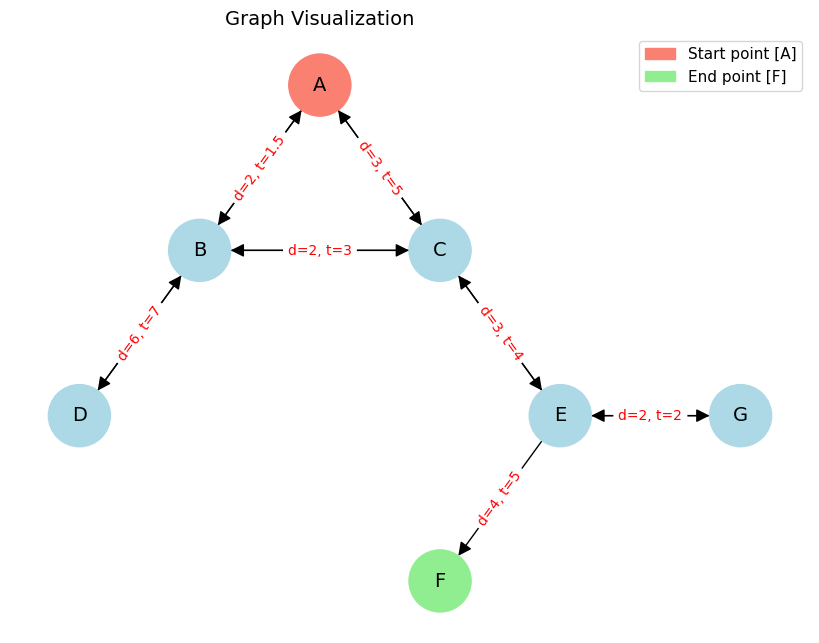

In [ ]:
visualize_graph(graph)

# Agent Training Process

In [ ]:
# Training the Q-Learning agent
for episode in range(episodes):
    # Start at the initial state
    current_state = 'A'
    visited_states = set()
    while current_state != 'F':  # 'F' is the destination
        current_index = state_to_index[current_state]
        valid_actions = list(graph[current_state].keys())
        valid_indices = [state_to_index[action] for action in valid_actions]

        # Find the best Q-value among valid actions
        q_values = [q_table[current_index, idx] for idx in valid_indices]
        next_state_index = valid_indices[np.argmax(q_values)]
        next_state = index_to_state[next_state_index]

        # Get the distance and time for the selected action
        distance = graph[current_state][next_state]['distance']
        time = graph[current_state][next_state]['time'] * traffic_factor  # Adjust for traffic

        # Reward: Positive rewards with penalties for revisits
        reward = 1 / (distance + time + 1e-7)  # Inverse of cost
        if next_state in visited_states:
            reward -= 5  # Additional penalty for revisiting

        # Update Q-value using the Q-learning formula
        current_index = state_to_index[current_state]
        next_state_index = state_to_index[next_state]
        q_table[current_index, next_state_index] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_state_index]) - q_table[current_index, next_state_index]
        )

        # Mark state as visited and move to the next state
        visited_states.add(current_state)
        current_state = next_state

print("Training Done!")

Training Done!


In [ ]:
# Display the learned Q-table
print("Learned Q-Table:")
# print(q_table)
print(np.array_str(q_table, precision=3, suppress_small=True))

Learned Q-Table:
[[ 0.    -2.056  0.24   0.     0.     0.     0.   ]
 [-2.418  0.    -2.118 -1.469  0.     0.     0.   ]
 [-1.471 -2.464  0.     0.     0.181  0.     0.   ]
 [ 0.    -2.516  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.459  0.     0.     0.087  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


In [ ]:
def find_multiple_paths(start, destination, num_trials=5):
    paths = []
    for i in range(1, num_trials+1):
        route = [start]
        current_state = start
        total_distance = 0
        total_time = 0
        visited_states = set()  # To prevent revisiting states
        step_limit = 100  # Maximum steps to prevent infinite loops
        steps = 0

        while current_state != destination and steps < step_limit:
            current_index = state_to_index[current_state]

            # Filter valid actions (neighboring states)
            valid_actions = list(graph[current_state].keys())
            valid_indices = [state_to_index[action] for action in valid_actions]

            # Break if no valid actions are available
            if not valid_actions:
                print(f"No valid actions from state {current_state}.")
                break

            steps += 1

            # Choose the next state based on epsilon-greedy strategy
            if random.random() < epsilon:  # Probability 3:7 (epsilon=0.3)
                next_state_index = random.choice(valid_indices)
                # print(f"Exploring: Randomly chosen next state.")
            else:
                # Choose the next state based on Q-values
                q_values = [q_table[current_index, idx] for idx in valid_indices]
                next_state_index = valid_indices[np.argmax(q_values)]
                # print(f"Exploiting: Choosing best Q-value.")

            next_state = index_to_state[next_state_index]

            # Skip states already visited
            if next_state in visited_states:
                continue  # Try another valid state

            # Accumulate distance and time
            total_distance += graph[current_state][next_state]['distance']
            total_time += graph[current_state][next_state]['time'] * traffic_factor

            # Update visited states and route
            visited_states.add(next_state)
            route.append(next_state)
            current_state = next_state

        # Add the path if it reaches the destination
        if current_state == destination:
            if (route, total_distance, total_time) in paths:
                print(f"[=] Route already explored.")
                print(f"    {' -> '.join(route)}")
            else:
                paths.append((route, total_distance, total_time))
                print("[+] New route found:")
                print(f"    {' -> '.join(route)}")
                print(f"Total Distance: {total_distance}, Total Time: {total_time}")
        else:
            print(f"[-] Path did not reach destination: {' -> '.join(route)}")

        print(f"{'-'*65} ({i})")

    return paths

In [ ]:
# Test the function
multi_paths = find_multiple_paths('A', 'F', num_trials=10)

[-] Path did not reach destination: A -> C -> E -> G
------------------------------------------------------------ (1)
[-] Path did not reach destination: A -> C -> E -> G
------------------------------------------------------------ (2)
[-] Path did not reach destination: A -> B -> D
------------------------------------------------------------ (3)
[+] New route found:
    A -> C -> E -> F
Total Distance: 10, Total Time: 21.0
------------------------------------------------------------ (4)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (5)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (6)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (7)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (8)
[=] Route already explored.
    A -> C -> E -> F
--

In [ ]:
def get_optimal_path(paths) :
    optimal_path = None
    for path, distance, time in paths:
        if optimal_path is None or time < optimal_path[2] or (time == optimal_path[2] and distance < optimal_path[1]):
            optimal_path = (path, distance, time)
    print(f"Optimal Path: {' -> '.join(optimal_path[0])}")
    print(f"Total Distance: {optimal_path[1]}, Total Time: {optimal_path[2]}")
    return optimal_path

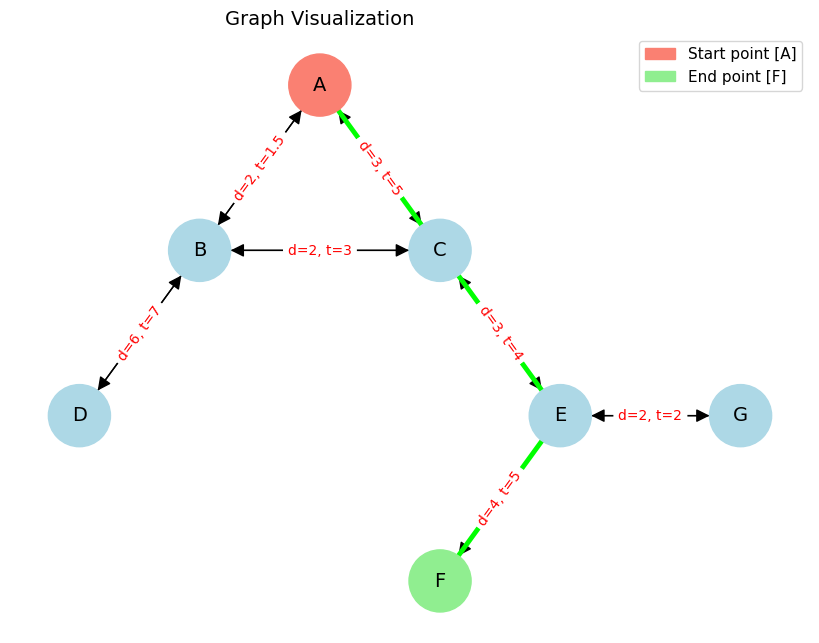

In [ ]:
optimal_path, _, _ = get_optimal_path(multi_paths)
visualize_graph(graph, optimal_path)

# Finding the Best Hyperparameter (Fine Tuning)

In [ ]:
q_table = np.zeros((len(states), len(actions)))  # Reset Q-table with zeros

# Updated Hyperparameters
learning_rate = 0.1  # Alpha; previous = 0.3
discount_factor = 0.9  # Gamma; previous = 0.8
epsilon = 0.3  # Exploration rate; same as previous
episodes = 100  # Number of episodes; same as previous
traffic_factor = 1.5  # Simulate traffic impact; same as previous

In [ ]:
# Training the Q-Learning agent
for episode in range(episodes):
    # Start at the initial state
    current_state = 'A'
    visited_states = set()
    while current_state != 'F':  # 'F' is the destination
        current_index = state_to_index[current_state]
        valid_actions = list(graph[current_state].keys())
        valid_indices = [state_to_index[action] for action in valid_actions]

        # Find the best Q-value among valid actions
        q_values = [q_table[current_index, idx] for idx in valid_indices]
        next_state_index = valid_indices[np.argmax(q_values)]
        next_state = index_to_state[next_state_index]

        # Get the distance and time for the selected action
        distance = graph[current_state][next_state]['distance']
        time = graph[current_state][next_state]['time'] * traffic_factor  # Adjust for traffic

        # Reward: Positive rewards with penalties for revisits
        reward = 1 / (distance + time + 1e-7)  # Inverse of cost
        if next_state == 'F':
            reward += 15  # Bonus reward for reaching the destination
        elif next_state in visited_states:
            reward -= 5  # Additional penalty for revisiting
        else:
            reward -= 1  # Penalty for not reaching the destination

        # Update Q-value using the Q-learning formula
        current_index = state_to_index[current_state]
        next_state_index = state_to_index[next_state]
        q_table[current_index, next_state_index] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_state_index]) - q_table[current_index, next_state_index]
        )

        # Mark state as visited and move to the next state
        visited_states.add(current_state)
        current_state = next_state

print("Training Done!")

Training Done!


In [ ]:
# Display the learned Q-table
print("Learned Q-Table:")
# print(q_table)
print(np.array_str(q_table, precision=3, suppress_small=True))

Learned Q-Table:
[[ 0.     8.667 -1.005  0.     0.     0.     0.   ]
 [-1.291  0.    10.551 -1.047  0.     0.     0.   ]
 [-0.932 -0.921  0.     0.    12.685  0.     0.   ]
 [ 0.    -1.699  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.489  0.     0.    15.087  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


In [ ]:
# Test the function
multi_paths = find_multiple_paths('A', 'F', num_trials=10)

[+] New route found:
    A -> B -> C -> E -> F
Total Distance: 11, Total Time: 20.25
------------------------------------------------------------ (1)
[-] Path did not reach destination: A -> B -> C -> E -> G
------------------------------------------------------------ (2)
[+] New route found:
    A -> C -> E -> F
Total Distance: 10, Total Time: 21.0
------------------------------------------------------------ (3)
[=] Route already explored.
    A -> B -> C -> E -> F
------------------------------------------------------------ (4)
[=] Route already explored.
    A -> B -> C -> E -> F
------------------------------------------------------------ (5)
[=] Route already explored.
    A -> B -> C -> E -> F
------------------------------------------------------------ (6)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (7)
[-] Path did not reach destination: A -> B -> C -> A
-----------------------------------------------------------

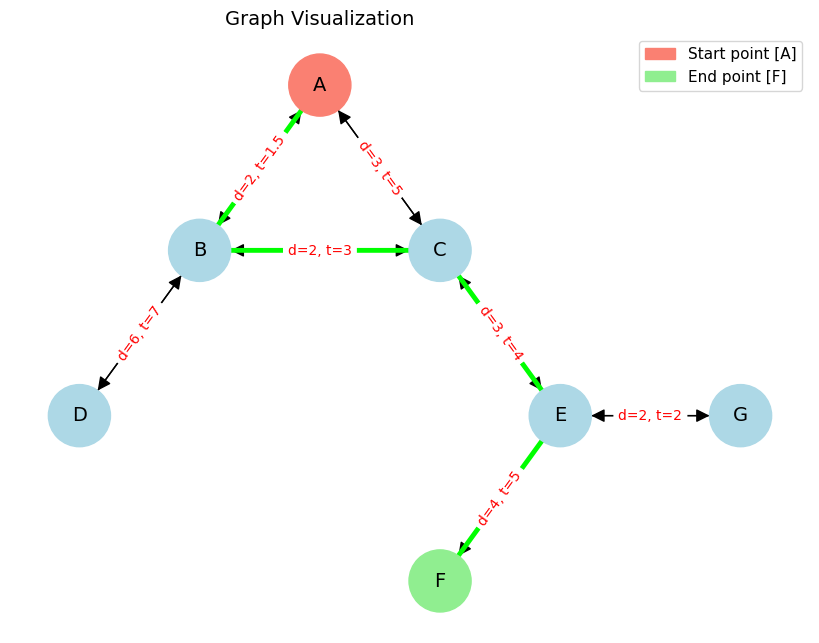

In [ ]:
optimal_path, _, _ = get_optimal_path(multi_paths)
visualize_graph(graph, optimal_path)

# Final Class (Reusable)

In [34]:
import numpy as np
import random

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class PathFinder:
    def __init__(self, graph, start_point, end_point, traffic_factor=1.5, q_table=None):
        self.graph = graph
        self.graph[end_point] = {}   # One-way to destination; If reached, then finish
        self.start_point = start_point
        self.end_point = end_point
        self.traffic_factor = traffic_factor

        # Initialize Best Hyperparameters
        self.episodes = 100
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.epsilon = 0.3

        self._states = list(graph.keys())
        self._state_to_index = {state: idx for idx, state in enumerate(self._states)}
        self._index_to_state = {idx: state for state, idx in self._state_to_index.items()}

        # Initialize the Q-table if not provided, make it private with an underscore
        if q_table is None:
            self._q_table = np.zeros((len(self._states), len(self._states)))  # Q-table initialized with zeros
        else:
            self._q_table = q_table

        # Variable to track the optimal path found
        self.optimal_path = None

    def visualize_graph(self, path=None):
        # Create a directed graph using NetworkX
        G = nx.DiGraph()

        # Add edges with attributes
        for node, neighbors in self.graph.items():
            for neighbor, attributes in neighbors.items():
                G.add_edge(node, neighbor, distance=attributes['distance'], time=attributes['time'])

        # Create edge labels for visualization
        edge_labels = {(u, v): f"d={d['distance']}, t={d['time']}" for u, v, d in G.edges(data=True)}

        # Updated positions
        pos = {
            'A': (0, 3),    # A at the top
            'B': (-1, 2),   # B slightly left below A
            'C': (1, 2),    # C slightly right below A
            'D': (-2, 1),   # D further left below B
            'E': (2, 1),    # E further right below C
            'F': (1, 0),    # F at the bottom right
            'G': (3.5, 1)   # G at the bottom center
        }

        # Highlight an example path if provided
        if path:
            path_edges = list(zip(path, path[1:]))
        else:
            # Highlight the optimal path if no path is provided
            if self.optimal_path:
                route, _, _ = self.optimal_path
                path_edges = list(zip(route, route[1:]))
            else:
                path_edges = []

        # Define node colors, with start and end points colored green
        custom_node_colors = {
            self.start_point: 'salmon',
            self.end_point: 'lightgreen',
        }
        node_colors = [custom_node_colors[node] if node in [self.start_point, self.end_point] else 'lightblue' for node in G.nodes]

        # Draw the graph
        plt.figure(figsize=(8, 6))
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=14, arrowsize=20)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='lime', width=3.5)  # Highlight the path
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

        # Create legend handles for start and end points
        start_patch = mpatches.Patch(color='salmon', label=f'Start point [{self.start_point}]')
        end_patch = mpatches.Patch(color='lightgreen', label=f'End point [{self.end_point}]')

        # Add legend to the plot
        plt.legend(handles=[start_patch, end_patch], loc='best', fontsize=11)

        # Add a title and show the graph
        plt.title("Graph Visualization                             ", fontsize=14)

        plt.show()

    def train(self, episodes=100, learning_rate=0.1, discount_factor=0.9):
        # Update Hyperparameters
        self.episodes = episodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Train the Q-Learning agent
        for _ in range(self.episodes):
            current_state = self.start_point
            visited_states = set()
            route = [current_state]
            total_distance = 0
            total_time = 0
            while current_state != self.end_point:
                # Choose an action (explore or exploit)
                current_index = self._state_to_index[current_state]
                valid_actions = list(self.graph[current_state].keys())
                valid_indices = [self._state_to_index[action] for action in valid_actions]

                # Find the best Q-value among valid actions
                q_values = [self._q_table[current_index, idx] for idx in valid_indices]
                next_state_index = valid_indices[np.argmax(q_values)]
                next_state = self._index_to_state[next_state_index]

                # Get the distance and time for the selected action
                distance = self.graph[current_state][next_state]['distance']
                time = self.graph[current_state][next_state]['time'] * self.traffic_factor  # Adjust for traffic

                # Reward: Positive rewards with penalties for revisits
                reward = 1 / (distance + time + 1e-7)  # Inverse of cost
                if next_state == self.end_point:
                    reward += 15  # Bonus reward for reaching the destination
                elif next_state in visited_states:
                    reward -= 5  # Additional penalty for revisiting
                else:
                    reward -= 1  # Penalty for not reaching the destination

                # Update Q-value using the Q-learning formula
                next_state_index = self._state_to_index[next_state]
                self._q_table[current_index, next_state_index] += self.learning_rate * (
                    reward + self.discount_factor * np.max(self._q_table[next_state_index]) - self._q_table[current_index, next_state_index]
                )

                # Mark state as visited and move to the next state
                visited_states.add(current_state)
                current_state = next_state
                route.append(current_state)
                total_distance += distance
                total_time += time

            # Check if this is the optimal path (shortest time/ distance path found so far)
            # if self.optimal_path is None or total_distance + total_time < self.optimal_path[1] + self.optimal_path[2]:
            if self.optimal_path is None or total_time < self.optimal_path[2] or (total_time == self.optimal_path[2] and total_distance < self.optimal_path[1]):
                self.optimal_path = (route, total_distance, total_time)

        print("Agent training Done!")

    def get_optimal_path(self, show_graph=False):
        # Check if Q-table has been trained (if it's still zeros)
        if np.all(self._q_table == 0):
            print("Please train the agent first!")
            return

        # Get the optimal path from start_point to end_point based on the trained Q-table
        if self.optimal_path:
            route, total_distance, total_time = self.optimal_path
            print(f"Optimal Path: {' -> '.join(route)}")
            print(f"Total Distance: {total_distance}, Total Time: {total_time}")
            if show_graph:
                self.visualize_graph(route)
            return self.optimal_path
        else:
            print("No optimal path found.")

    def get_q_table(self):
        # Check if Q-table has been trained (if it's still zeros)
        if np.all(self._q_table == 0):
            print("Please train the agent first!")
            return

        # Getter method for accessing the Q-table (read-only)
        print("Q-table:")
        # print(self._q_table)
        print(np.array_str(self._q_table, precision=3, suppress_small=True))
        return self._q_table

    def find_multiple_paths(self, epsilon=0.3, num_trials=5, start=None, destination=None):
        # Update epsilon for this method
        self.epsilon = epsilon

        # Use class attributes if user does not provide custom points
        start = start if start is not None else self.start_point
        destination = destination if destination is not None else self.end_point

        paths = []
        for i in range(1, num_trials + 1):
            route = [start]
            current_state = start
            total_distance = 0
            total_time = 0
            visited_states = set()  # To prevent revisiting states
            step_limit = 100  # Maximum steps to prevent infinite loops
            steps = 0

            while current_state != destination and steps < step_limit:
                current_index = self._state_to_index[current_state]

                # Filter valid actions (neighboring states)
                valid_actions = list(self.graph[current_state].keys())
                valid_indices = [self._state_to_index[action] for action in valid_actions]

                # Break if no valid actions are available
                if not valid_actions:
                    print(f"No valid actions from state {current_state}.")
                    break

                steps += 1

                # Choose the next state based on epsilon-greedy strategy
                if random.random() < self.epsilon:
                    next_state_index = random.choice(valid_indices)
                    # print(f"Exploring: Randomly chosen next state.")
                else:
                    # Choose the next state based on Q-values
                    q_values = [self._q_table[current_index, idx] for idx in valid_indices]
                    next_state_index = valid_indices[np.argmax(q_values)]
                    # print(f"Exploiting: Choosing best Q-value.")

                next_state = self._index_to_state[next_state_index]

                # Skip states already visited
                if next_state in visited_states:
                    continue  # Try another valid state

                # Accumulate distance and time
                total_distance += self.graph[current_state][next_state]['distance']
                total_time += self.graph[current_state][next_state]['time'] * self.traffic_factor

                # Update visited states and route
                visited_states.add(next_state)
                route.append(next_state)
                current_state = next_state

            # Add the path if it reaches the destination
            if current_state == destination:
                if (route, total_distance, total_time) in paths:
                    print(f"[=] Route already explored.")
                    print(f"    {' -> '.join(route)}")
                else:
                    paths.append((route, total_distance, total_time))
                    print("[+] New route found:")
                    print(f"    {' -> '.join(route)}")
                    print(f"Total Distance: {total_distance}, Total Time: {total_time}")
            else:
                print(f"[-] Path did not reach destination: {' -> '.join(route)}")

            print(f"{'-'*65} ({i})")

        return paths

In [35]:
# Example usage:
graph = {
    'A': {'B': {'distance': 2, 'time': 1.5}, 'C': {'distance': 3, 'time': 5}},
    'B': {'A': {'distance': 2, 'time': 1.5}, 'C': {'distance': 2, 'time': 3}, 'D': {'distance': 6, 'time': 7}},
    'C': {'A': {'distance': 3, 'time': 5}, 'B': {'distance': 2, 'time': 3}, 'E': {'distance': 3, 'time': 4}},
    'D': {'B': {'distance': 6, 'time': 7}},
    'E': {'C': {'distance': 3, 'time': 4}, 'F': {'distance': 4, 'time': 5}, 'G': {'distance': 2, 'time': 2}},
    'F': {'E': {'distance': 4, 'time': 5}},
    'G': {'E': {'distance': 2, 'time': 2}},
}

### Testing A --> G

In [36]:
# Initialize PathFinder with custom start and end points
path_finder = PathFinder(graph=graph, start_point='A', end_point='G')

In [37]:
# Trying to access the Q-table before training
q_table = path_finder.get_q_table()

Please train the agent first!


In [38]:
# Train the agent
path_finder.train()

Agent training Done!


In [21]:
# Access the Q-table (after training)
q_table = path_finder.get_q_table()

Q-table:
[[ 0.     8.748 -1.005  0.     0.     0.     0.   ]
 [-1.291  0.    10.642 -1.047  0.     0.     0.   ]
 [-0.932 -0.921  0.     0.    12.787  0.     0.   ]
 [ 0.    -1.699  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.489  0.     0.    -0.091 15.2  ]
 [ 0.     0.     0.     0.    -0.491  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


In [22]:
# Get and print the optimal path
optimal_path = path_finder.get_optimal_path()

Optimal Path: A -> B -> C -> E -> G
Total Distance: 9, Total Time: 15.75


Optimal Path: A -> B -> C -> E -> G
Total Distance: 9, Total Time: 15.75


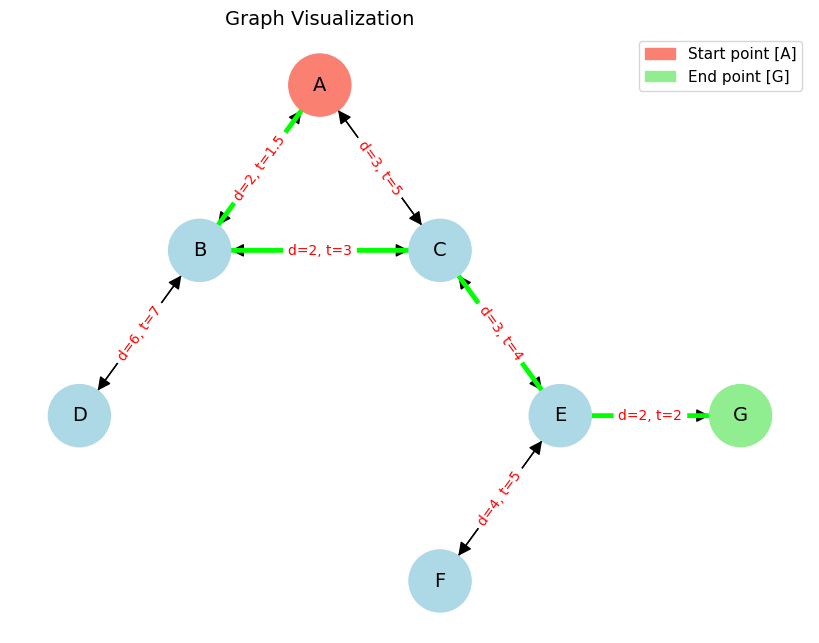

In [23]:
# Get the optimal path and visualize the path in graphic
optimal_path = path_finder.get_optimal_path(show_graph=True)

In [ ]:
# Find multiple paths
multiple_paths = path_finder.find_multiple_paths(num_trials=10)

[-] Path did not reach destination: A -> B -> C -> E -> F
------------------------------------------------------------ (1)
[+] New route found:
    A -> C -> E -> G
Total Distance: 8, Total Time: 16.5
------------------------------------------------------------ (2)
[-] Path did not reach destination: A -> B -> C -> E -> F
------------------------------------------------------------ (3)
[+] New route found:
    A -> B -> A -> C -> E -> G
Total Distance: 12, Total Time: 21.0
------------------------------------------------------------ (4)
[=] Route already explored.
    A -> C -> E -> G
------------------------------------------------------------ (5)
[+] New route found:
    A -> B -> C -> E -> G
Total Distance: 9, Total Time: 15.75
------------------------------------------------------------ (6)
[-] Path did not reach destination: A -> B -> C -> E -> F
------------------------------------------------------------ (7)
[=] Route already explored.
    A -> B -> C -> E -> G
-----------------

In [ ]:
# Find multiple customized paths
multiple_paths = path_finder.find_multiple_paths(start='A', destination='D', num_trials=10)

No valid actions from state G.
[-] Path did not reach destination: A -> B -> C -> E -> G
------------------------------------------------------------ (1)
No valid actions from state G.
[-] Path did not reach destination: A -> B -> C -> E -> G
------------------------------------------------------------ (2)
No valid actions from state G.
[-] Path did not reach destination: A -> C -> E -> G
------------------------------------------------------------ (3)
No valid actions from state G.
[-] Path did not reach destination: A -> B -> C -> E -> G
------------------------------------------------------------ (4)
No valid actions from state G.
[-] Path did not reach destination: A -> C -> E -> G
------------------------------------------------------------ (5)
No valid actions from state G.
[-] Path did not reach destination: A -> B -> C -> E -> G
------------------------------------------------------------ (6)
[-] Path did not reach destination: A -> B -> C -> A
---------------------------------

### Testing A --> F

In [ ]:
# Initialize PathFinder with custom start and end points
path_finder = PathFinder(graph=graph, start_point='A', end_point='F')

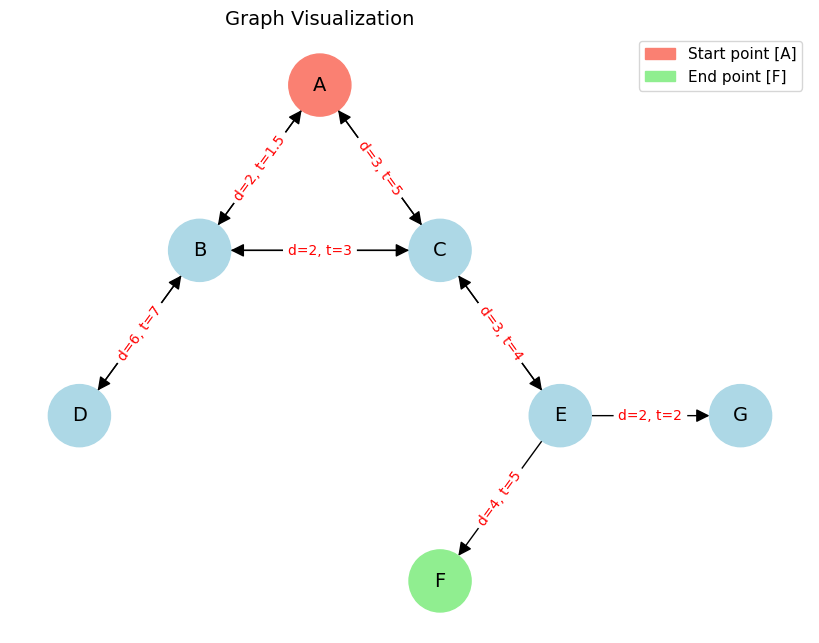

In [ ]:
# Visualize Graph
path_finder.visualize_graph()

In [ ]:
# Train the agent
path_finder.train()

Agent training Done!


In [ ]:
# Access the Q-table (after training)
q_table = path_finder.get_q_table()

Q-table:
[[ 0.     8.667 -1.005  0.     0.     0.     0.   ]
 [-1.291  0.    10.551 -1.047  0.     0.     0.   ]
 [-0.932 -0.921  0.     0.    12.685  0.     0.   ]
 [ 0.    -1.699  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.489  0.     0.    15.087  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


In [ ]:
# Get and print the optimal path
optimal_path = path_finder.get_optimal_path()

Optimal Path: A -> B -> C -> E -> F
Total Distance: 11, Total Time: 20.25


Optimal Path: A -> B -> C -> E -> F
Total Distance: 11, Total Time: 20.25


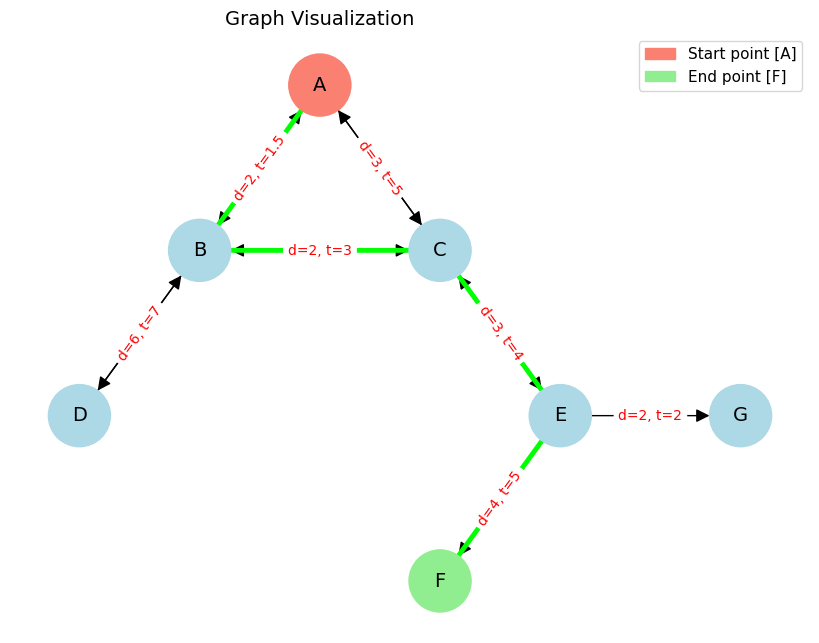

In [ ]:
# Get the optimal path and visualize the path in graphic
optimal_path = path_finder.get_optimal_path(show_graph=True)

In [ ]:
# Find multiple paths
multiple_paths = path_finder.find_multiple_paths(num_trials=10)

[+] New route found:
    A -> B -> C -> E -> F
Total Distance: 11, Total Time: 20.25
------------------------------------------------------------ (1)
[=] Route already explored.
    A -> B -> C -> E -> F
------------------------------------------------------------ (2)
[-] Path did not reach destination: A -> C -> E -> G
------------------------------------------------------------ (3)
[+] New route found:
    A -> C -> E -> F
Total Distance: 10, Total Time: 21.0
------------------------------------------------------------ (4)
[-] Path did not reach destination: A -> B -> C -> A
------------------------------------------------------------ (5)
[=] Route already explored.
    A -> C -> E -> F
------------------------------------------------------------ (6)
[-] Path did not reach destination: A -> B -> C -> A
------------------------------------------------------------ (7)
[=] Route already explored.
    A -> B -> C -> E -> F
------------------------------------------------------------ (8)


In [ ]:
# Find multiple customized paths
multiple_paths = path_finder.find_multiple_paths(start='A', destination='D', num_trials=10)

No valid actions from state F.
[-] Path did not reach destination: A -> B -> C -> E -> F
----------------------------------------------------------------- (1)
No valid actions from state F.
[-] Path did not reach destination: A -> B -> C -> E -> F
----------------------------------------------------------------- (2)
[+] New route found:
    A -> B -> D
Total Distance: 8, Total Time: 12.75
----------------------------------------------------------------- (3)
No valid actions from state F.
[-] Path did not reach destination: A -> B -> C -> E -> F
----------------------------------------------------------------- (4)
No valid actions from state F.
[-] Path did not reach destination: A -> B -> C -> E -> F
----------------------------------------------------------------- (5)
No valid actions from state F.
[-] Path did not reach destination: A -> B -> C -> E -> F
----------------------------------------------------------------- (6)
[-] Path did not reach destination: A -> B -> C -> E -> G
---

### Testing D --> F

In [ ]:
# Initialize PathFinder with custom start and end points
path_finder = PathFinder(graph=graph, start_point='D', end_point='F')

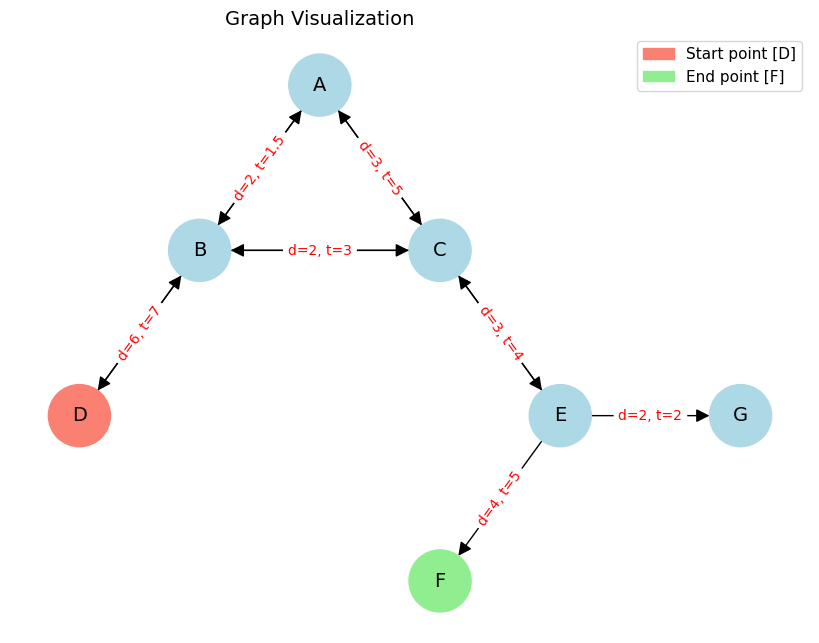

In [ ]:
# Visualize Graph
path_finder.visualize_graph()

In [ ]:
# Train the agent
path_finder.train()

Agent training Done!


In [ ]:
# Access the Q-table (after training)
q_table = path_finder.get_q_table()

Q-table:
[[ 0.    -1.291 -0.963  0.     0.     0.     0.   ]
 [-1.005  0.    10.551 -1.339  0.     0.     0.   ]
 [-0.932 -0.921  0.     0.    12.685  0.     0.   ]
 [ 0.     8.492  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.489  0.     0.    15.087  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]


In [ ]:
# Get and print the optimal path
optimal_path = path_finder.get_optimal_path()

Optimal Path: D -> B -> C -> E -> F
Total Distance: 15, Total Time: 28.5


Optimal Path: D -> B -> C -> E -> F
Total Distance: 15, Total Time: 28.5


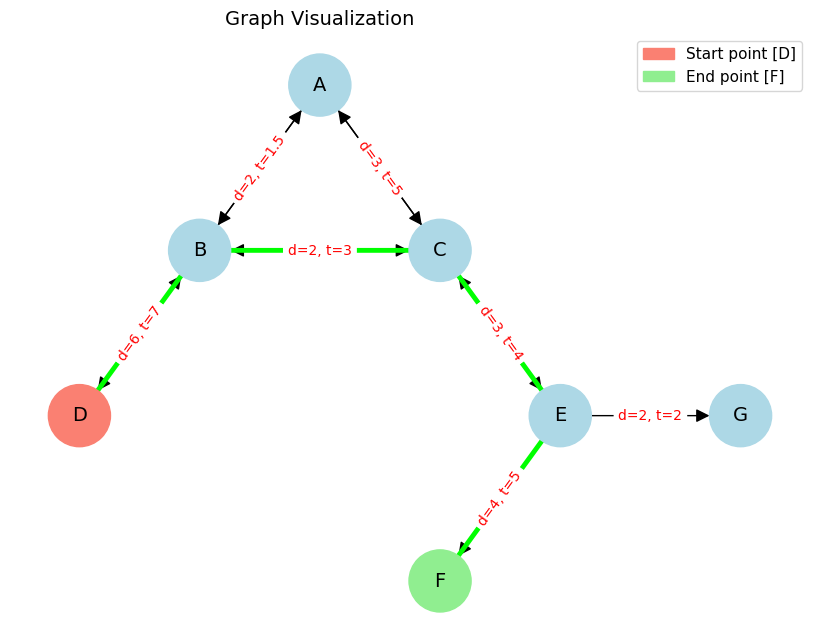

In [ ]:
# Get the optimal path and visualize the path in graphic
optimal_path = path_finder.get_optimal_path(show_graph=True)

In [ ]:
# Find multiple paths
multiple_paths = path_finder.find_multiple_paths(num_trials=10)

[-] Path did not reach destination: D -> B -> D
------------------------------------------------------------ (1)
No valid actions from state G.
[-] Path did not reach destination: D -> B -> C -> E -> G
------------------------------------------------------------ (2)
[+] New route found:
    D -> B -> C -> E -> F
Total Distance: 15, Total Time: 28.5
------------------------------------------------------------ (3)
[=] Route already explored.
    D -> B -> C -> E -> F
------------------------------------------------------------ (4)
[=] Route already explored.
    D -> B -> C -> E -> F
------------------------------------------------------------ (5)
[=] Route already explored.
    D -> B -> C -> E -> F
------------------------------------------------------------ (6)
[=] Route already explored.
    D -> B -> C -> E -> F
------------------------------------------------------------ (7)
[=] Route already explored.
    D -> B -> C -> E -> F
------------------------------------------------------

In [ ]:
# Find multiple customized paths
multiple_paths = path_finder.find_multiple_paths(start='D', destination='G', num_trials=10)

No valid actions from state F.
[-] Path did not reach destination: D -> B -> A -> C -> E -> F
----------------------------------------------------------------- (1)
No valid actions from state F.
[-] Path did not reach destination: D -> B -> C -> E -> F
----------------------------------------------------------------- (2)
[+] New route found:
    D -> B -> C -> E -> G
Total Distance: 13, Total Time: 24.0
----------------------------------------------------------------- (3)
No valid actions from state F.
[-] Path did not reach destination: D -> B -> C -> E -> F
----------------------------------------------------------------- (4)
[-] Path did not reach destination: D -> B -> C -> A
----------------------------------------------------------------- (5)
No valid actions from state F.
[-] Path did not reach destination: D -> B -> C -> E -> F
----------------------------------------------------------------- (6)
No valid actions from state F.
[-] Path did not reach destination: D -> B -> C -> 